<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/2023_DB_DS_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RB DS exercise

## Problem statement

Our client is a private dental clinic chain with a current network of 71 stores in France. The aim of this project is to understand what drives **center performance** and more precisely identify to what extent it is driven by **internal factors** such as quality of service or by **external factors** such as number of patients in the catchment area.

Therefore our team of consultants and data scientists has gathered **data on the clients' centers** and on the catchment areas surronding these centers. This data is available in the file attached *20231124_dental_center_data.xlsx*.

In order to solve this case please write your code in the cells below each question. Please feel free to add markdown cells to specify your reasoning and comment your code for easier understanding.

**Note: please make sure to use a version of Python > 3.9 and to import all the necessary packages in the cell right below**

In [204]:
# import your packages here
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,LeaveOneOut,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error as MSE,make_scorer,silhouette_score
from xgboost import XGBRegressor

from sklearn.cluster import SpectralClustering

In [139]:
# check your python version
!python -V

Python 3.10.12


Goal : The aim of this project is to understand what drives center performance and more precisely identify to what extent it is driven by internal factors such as quality of service or by external factors such as number of patients in the catchment area. <br>

Notes :

*   Que des variables quantitatives (int/float)
*   Ce n'est pas un probleme de regression ou de classification classique, on veut à la fois maximiser le revenue tout en assurant une marge conséquente
*   Pas beaucoup de données -> peu de variables dans nos modèles, pas de DL, enlever certaines variables peut être corrélées, Bootstrap Sampling ou CV, faire du feature engineering, data augmentation comme créer l'âge du centreou des ratios, modèles baysiens pour obtenir des incertitudes, stratifier les données, si plusieurs var correlées ne garder que celle qui possède le moins de valeur manquante
*    Avec ce dernier point, cela rend les données manquantes encore importantes -> Soit voir au cas par cas en intuitant un algo soit K-NN pour faire une moyenne avec ses clusters
*    Facteurs internes : revenue, r_margin (indicateurs de performance économique),
fte (effectif du personnel),
nbr_reviews, avg_rating (qualité perçue),
rent (coût de l’emplacement),
et l'Opening year (ancienneté)
*   Facteurs Externes : nbr_patients, patients_yearly_growth, patients_over_65,
median_revenue, r_unemployment, r_poverty (situation socio-économique),
ainsi que les densités
*   Les performances du cabinet pourront être expliquées par à la fois le revenu et r_margin -> Perf = α×log(revenue + jitter)+(1−α)×r_margin, α à adapter selon les objectifs du dentiste
*   Identifier quelles sont les variables qui sont importantes -> SHAP




## Question 1

Inspect the data in the *20231124_dental_center_data.xlsx* file and **perform a descriptive data analysis**. Sample questions could be:
- Are there missing values?
- Are there outliers or unexpected values?
- Which variables are correlated, to what extend?
- ...

**Note: do not hesitate to use data vizualisation to support your findings**

- Some missing values -> K NN
- some unexepcted values (density negative, id 9), sinon some outliers mais pas problématiques, voir avec le
- density are correlated -> PCA
- Globalement des variables asser symetriques et homogenes
- quelques features asser skewed positivement : les taux poverty,  unemployment, patients over 65, revenue and median_revenue ->  transformation logarithmique ou Box-Cox

In [140]:
pd.read_excel('20231124_dental_center_data 1.xlsx').columns

Index(['ID', 'Latitude', 'Longitude', 'Revenue [21; EUR m]',
       'Margin rate [21; %]', 'Dentist FTE [#]',
       'Number of reviews on Google [#]', 'Average Google rating',
       'Rent in the area [EUR/sqm]', 'Patients in the catchment area [#]',
       'Patients' yearly growth in the catchment area [%]',
       'Share of patients in the catchment area over 65 [%]',
       'Median revenue in catchment area [EUR]',
       'Unemployment rate in the catchment area [%]',
       'Poverty rate in the catchment area [%]',
       'Density of doctors in the catchment area [#/100k patients]',
       'Density of pharmacists in the catchment area [ #/100k patients]',
       'Density of dentists in the catchment area [#/100k]', 'Opening year'],
      dtype='object')

In [141]:
# your code here
data = pd.read_excel('20231124_dental_center_data 1.xlsx').drop('ID', axis = 1)
# Densist FTE = full-time equivalent
columns_mapping = {
    'Dentist FTE [#]': 'fte',
    'Margin rate [21; %]': 'r_margin',
    'Revenue [21; EUR m]': 'revenue',
    'Number of reviews on Google [#]': 'nbr_reviews',
    'Average Google rating': 'avg_rating',
    'Rent in the area [EUR/sqm]': 'rent',
    'Patients in the catchment area [#]': 'nbr_patients',
    'Share of patients in the catchment area over 65 [%]': 'patients_over_65',
    'Unemployment rate in the catchment area [%]': 'r_unemployment',
    'Median revenue in catchment area [EUR]': 'median_revenue',
    'Poverty rate in the catchment area [%]': 'r_poverty',
    'Patients\' yearly growth in the catchment area [%]': 'patients_yearly_growth',
    'Density of doctors in the catchment area [#/100k patients]': 'density_doctors',
    'Density of pharmacists in the catchment area [ #/100k patients]': 'density_pharmacists',
    'Density of dentists in the catchment area [#/100k]': 'density_dentists'
}

data = data.rename(columns=columns_mapping)

data.head()

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
0,48.804336,2.420931,2.4,0.18,7.0,190.0,3.552632,5731,58874.899010,-0.24,13.060859,23330.857143,7.8,13.615055,133.0,66,104,2019
1,49.895083,2.298487,2.6,0.21,9.0,153.0,4.039216,2708,39687.660222,0.18,13.514219,19647.037037,9.6,20.113324,173.0,33,121,2019
2,43.578549,7.119384,3.3,0.21,10.0,163.0,4.288344,4751,25370.677794,-0.68,33.162485,22524.666667,12.5,15.142544,177.0,69,112,2018
3,43.655764,1.370467,2.2,0.09,10.0,145.0,4.158621,3205,6945.136108,1.83,10.971403,23213.333333,8.1,8.124205,179.0,89,116,2020
4,44.879637,-0.570372,2.9,0.21,8.0,63.0,4.650794,3707,6992.074760,1.08,9.078928,19480.000000,7.4,30.930467,182.0,76,121,2019


In [142]:
data[["median_revenue"]].describe()

,median_revenue
count,71.000000
mean,23000.078755
std,4738.040804
min,14317.058824
25%,20218.888499
50%,22262.121212
75%,24000.727969
max,40315.194805


In [143]:
print(data.isna().sum()/len(data)*100)
#bcp de null relativement à la taille du data set
#Se pose la question de est ce que ce n'est pas nul au lieu d'être Nan pour les features revenue,density_doctors,nbr_patients
#Abérrant pour les features : r_poverty,r_unemployment
#nbr_reviews et avg_rating ont exactement le même nombre de Nan

Latitude                  0.000000
Longitude                 0.000000
revenue                   7.042254
r_margin                  7.042254
fte                       7.042254
nbr_reviews               4.225352
avg_rating                4.225352
rent                      0.000000
nbr_patients              1.408451
patients_yearly_growth    0.000000
patients_over_65          0.000000
median_revenue            0.000000
r_unemployment            1.408451
r_poverty                 1.408451
density_doctors           2.816901
density_pharmacists       0.000000
density_dentists          0.000000
Opening year              0.000000
dtype: float64


In [144]:
negative_values = (data < 0).sum()
print(negative_values) #valeur aberrante pour density

Latitude                   0
Longitude                  6
revenue                    0
r_margin                   4
fte                        0
nbr_reviews                0
avg_rating                 0
rent                       0
nbr_patients               0
patients_yearly_growth    34
patients_over_65           0
median_revenue             0
r_unemployment             0
r_poverty                  0
density_doctors            1
density_pharmacists        0
density_dentists           0
Opening year               0
dtype: int64


In [145]:
nan_revenue = data[data['revenue'].isna()]

In [146]:
nan_revenue #chercher une cause à pourquoi par renseigné : vient d'être crée ? Est fermé ? EN travaux en 2021 ? ou alors moyenne imputer ?
#iloc 37, on peut mettre tout à zero compte tenu qu'il a été crée en 2021 .. Pour les autres imputing !

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
17,48.736834,1.365297,NaN,NaN,NaN,19.0,4.578947,1590,16206.342013,-0.46,15.763840,17016.923077,7.2,24.174403,106.0,40,104,2016
20,49.023062,1.148888,NaN,NaN,NaN,10.0,4.700000,1844,17408.129904,-1.24,19.890533,18980.000000,8.1,15.407340,96.0,34,109,2019
29,48.959236,2.882169,NaN,NaN,NaN,33.0,4.060606,2870,23423.885548,0.61,13.688214,19556.153846,7.4,13.890370,100.0,44,78,2016
34,48.692024,6.181425,NaN,NaN,NaN,14.0,4.714286,2559,52741.353401,0.16,13.566230,21786.206897,7.8,17.647573,176.0,73,120,2018
37,43.838278,4.363345,NaN,NaN,NaN,NaN,NaN,1988,55887.755483,-0.12,21.732715,18604.666667,11.0,25.542045,150.0,72,114,2021


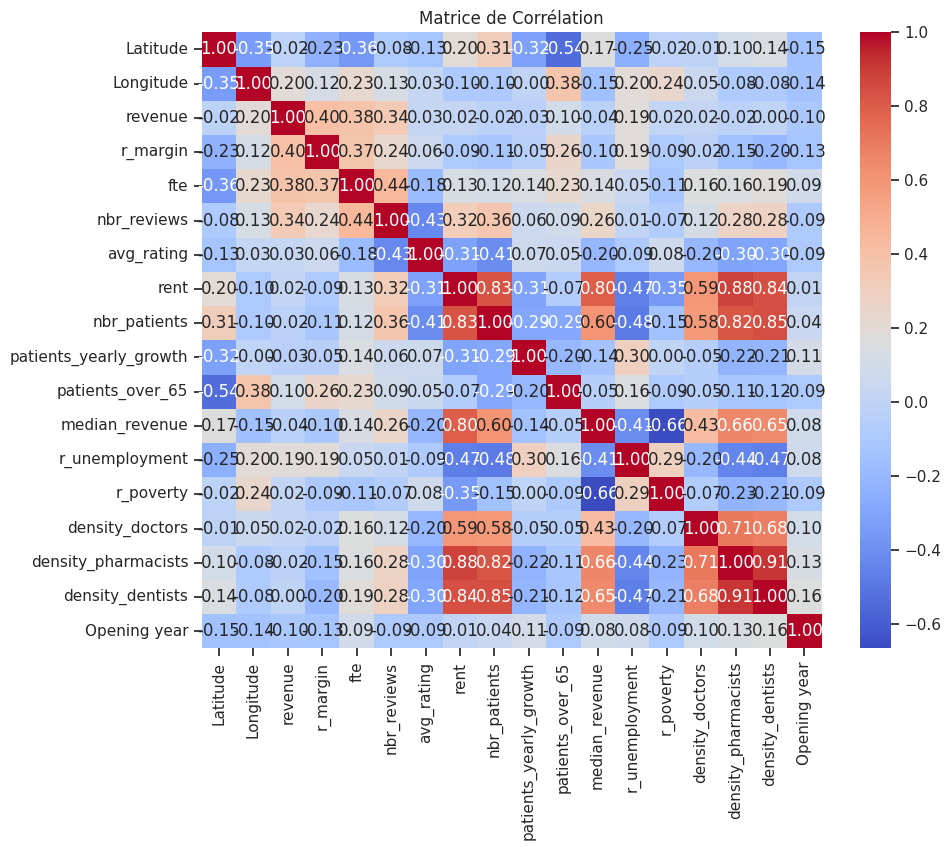

In [147]:
# Correlation forte entre les densities -> PCA
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

In [148]:
#sns.set_theme(style="ticks")
#sns.pairplot(data)

On voit bien ici une relation quasi linéaire entre plusieurs variables. Par Exemple (rent,median revenue),(fte, revnue), (revenue, r_margin) ...

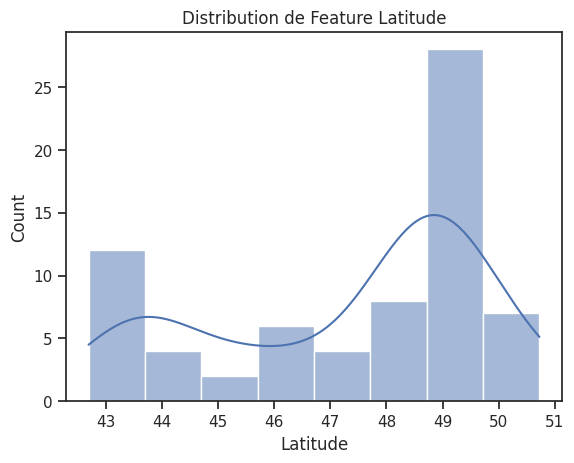

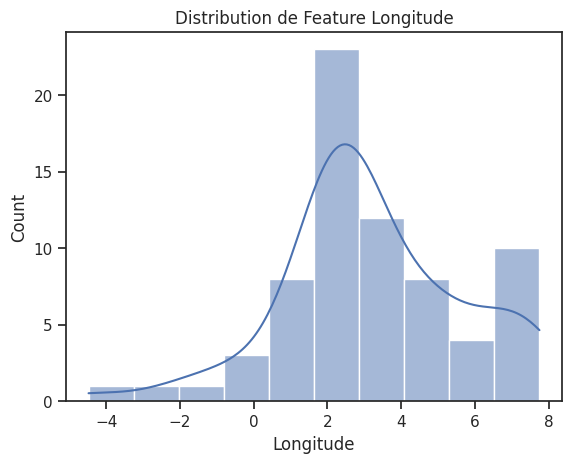

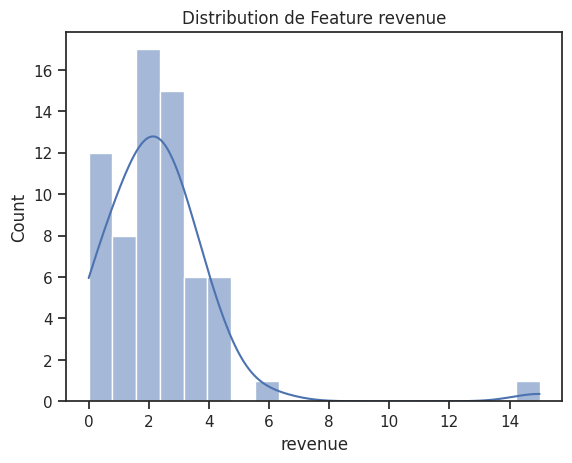

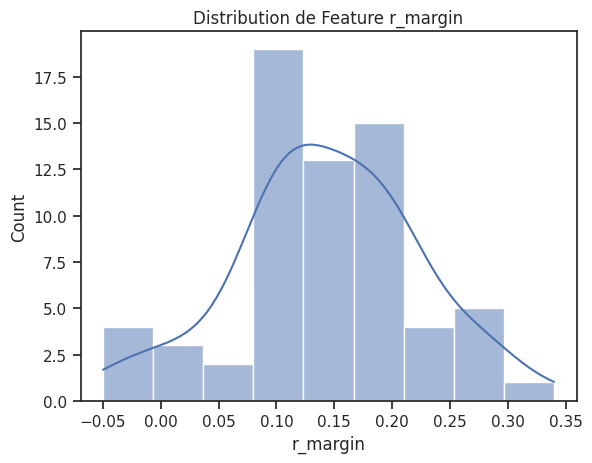

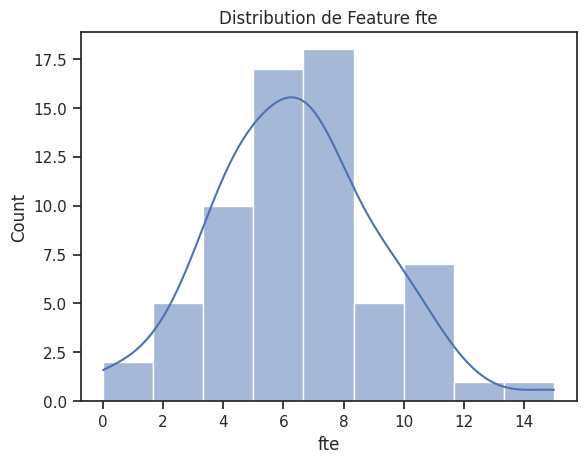

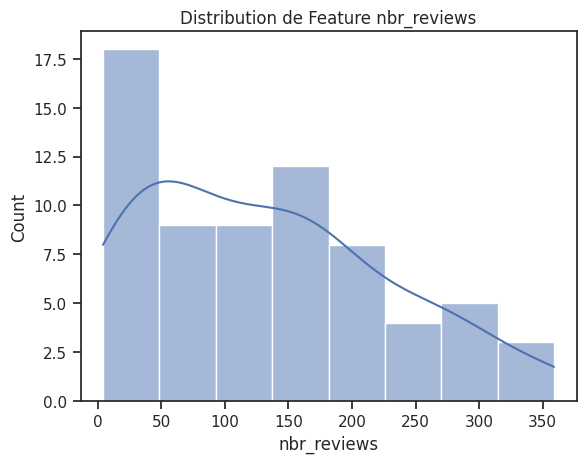

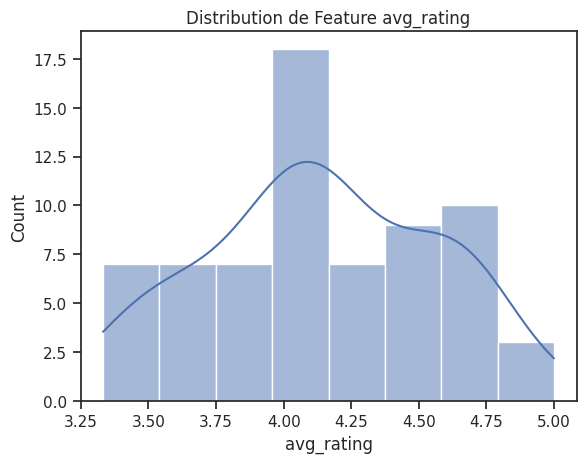

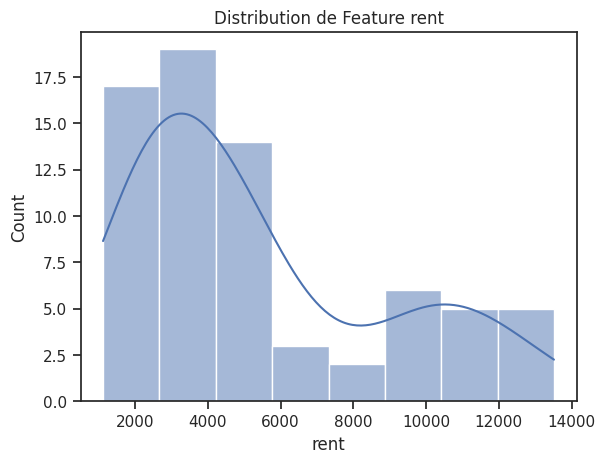

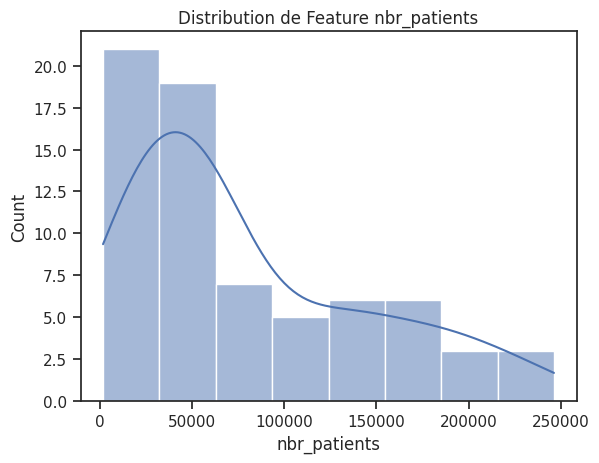

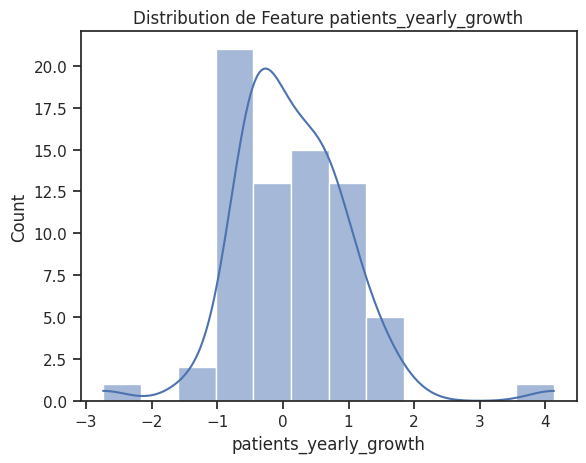

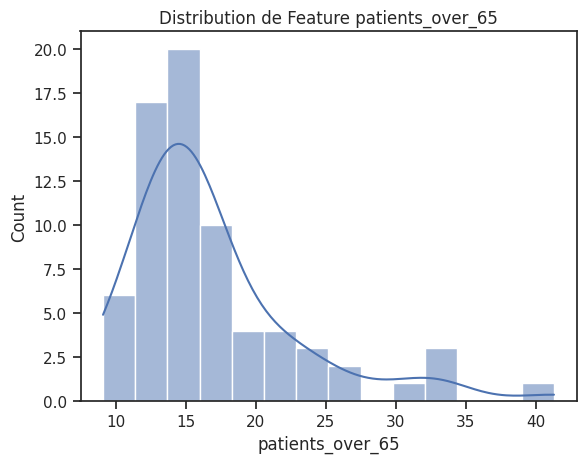

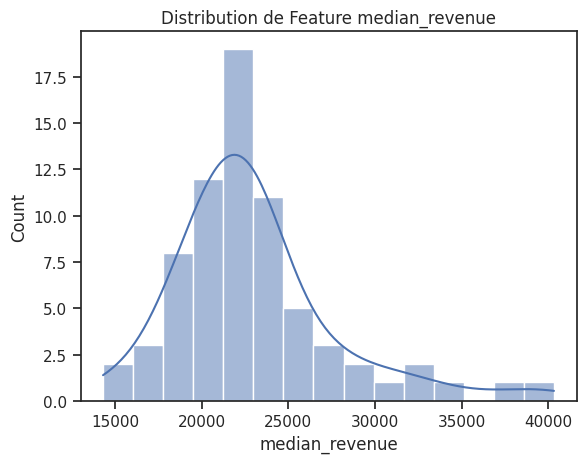

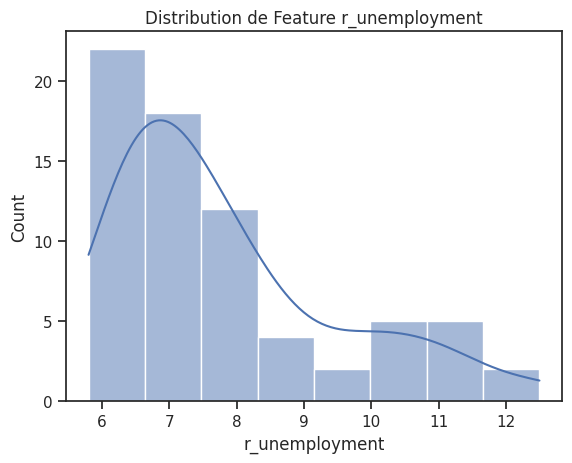

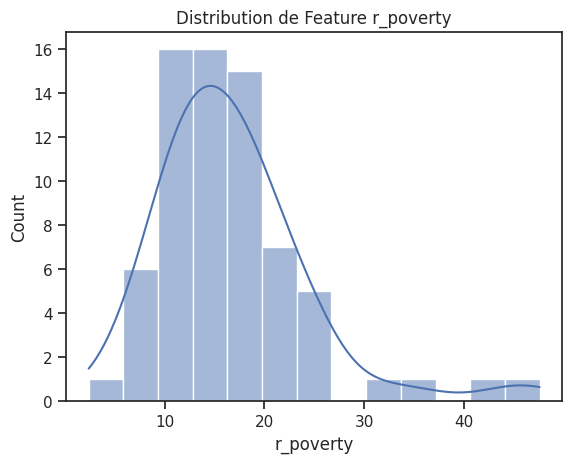

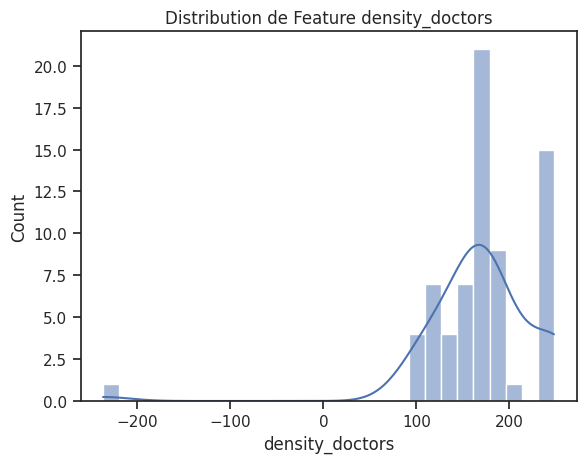

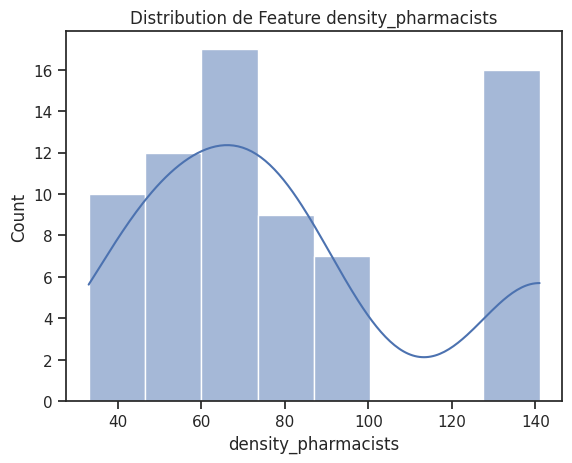

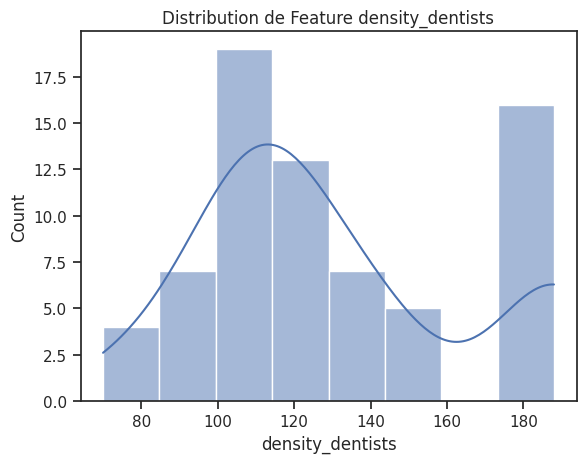

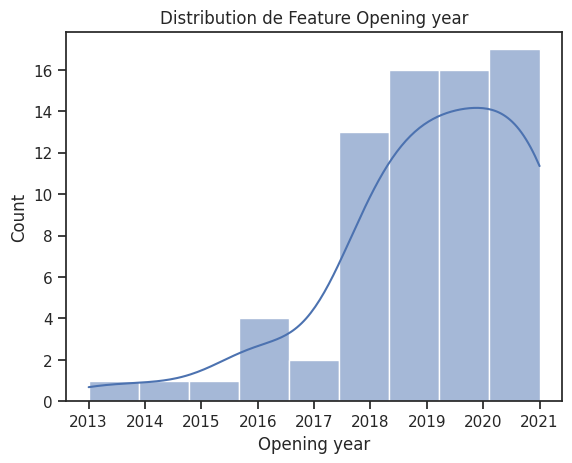

In [149]:
#Outlier dans revenue (14,6), patiens yearly growth, doctors in the catchment area
for c in data.columns:
  sns.histplot(data[c], kde=True)
  plt.title('Distribution de Feature' +' ' + str(c))
  plt.show()

In [150]:
imputer = KNNImputer(n_neighbors=5) # faire quelque chose de plus robuste pour la prochaine fois
data_imputed = imputer.fit_transform(data)
data_without_nan = pd.DataFrame(data_imputed, columns=data.columns)

In [151]:
skewness_stats = data_without_nan.apply(lambda x: skew(x))

# Affichage sous forme de tableau
skewness = pd.DataFrame({
    'Value': skewness_stats
})

skewness

,Value
Latitude,-0.596265
Longitude,-0.167659
revenue,3.712373
r_margin,-0.157672
fte,0.323097
nbr_reviews,0.541063
avg_rating,-0.086229
rent,0.887607
nbr_patients,0.939119
patients_yearly_growth,0.899073


In [152]:
(data_without_nan[data_without_nan['revenue']> 14])

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
69,50.616725,3.133466,15.0,0.19,4.0,46.0,4.891304,3484.0,24675.533216,0.04,9.05954,18853.333333,10.1,23.194949,166.0,55.0,113.0,2019.0


In [153]:
data_without_nan[["Opening year"]].describe()

,Opening year
count,71.000000
mean,2019.084507
std,1.762680
min,2013.000000
25%,2018.000000
50%,2019.000000
75%,2020.000000
max,2021.000000


#### Discussion sur la target à choisir

FTE, R_margin et revenue sont très corrélées

Différentes stratégie en fonction de l'objectif du cabinet :
- Si son objectif c'est le profit du centre : margin*revenue
- profit per dentist full-time equivalent : m*r/fte
- profitability adjusted for key operating costs : r*m /( FTE+Rent)
- Operational efficiency : margin
- PCA between some feratures
For the sake of thise mission We have choosen two type of objectives : profit per dentist, understanding that dental cabinet have a flat hierarchy, where every dentist has a share of it. And the absolute margin, optimizing the efficiency of the cabinet. Because we are on a business scope, creating a pca to represente a global perfomance feature, would not be adequate (not clear, not easy explicable)  

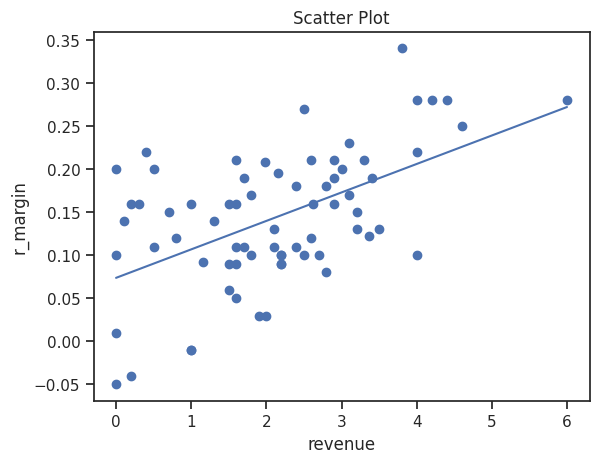

In [154]:
## Scatter entre revenue et r_margin
plt.scatter(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69))
plt.plot(np.unique(data_without_nan['revenue'].drop(69)), np.poly1d(np.polyfit(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69), 1))(np.unique(data_without_nan['revenue'].drop(69))))
plt.xlabel('revenue')
plt.ylabel('r_margin')
plt.title('Scatter Plot')
plt.show()

In [ ]:
#Create a target to see correlation
#data['target'] = data_transform1['revenue'] * data_transform1['r_margin']
#data_transform1.drop(69).plot.scatter(x='fte', y='revenue')

<Axes: xlabel='revenue', ylabel='Count'>

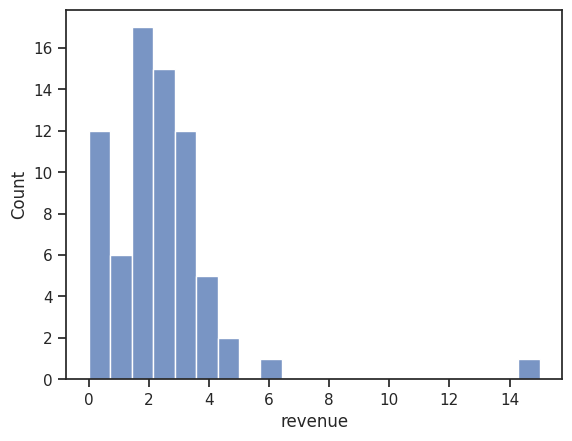

In [155]:
sns.histplot(data_without_nan['revenue'])

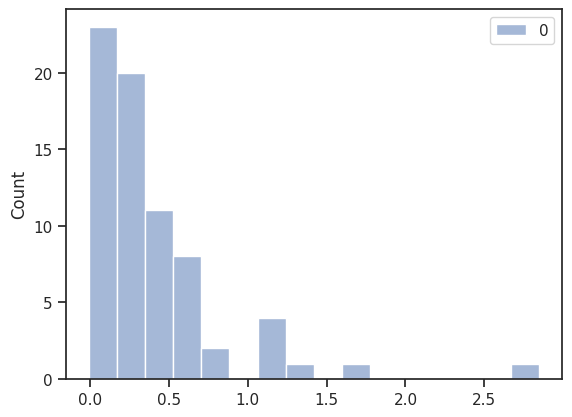

In [156]:
sns.histplot(pd.DataFrame(data_without_nan['revenue'] * data_without_nan['r_margin']))
plt.show()

In [157]:
#augmenter les données avec du réel !
## Voir si revenue = Nan <=> revnue = 0 cf data creation

## Question 2

Which variables **explain the largest share of center performance?** Are they rather linked to operational center performance or to the center's catchment area? Please try to **build a small supervised machine learning model** to support your findings.

Commencer avec une vision initiale : <br>
A priori, la duration ainsi que le nbr de reviews (et donc le nbr de clients) ainsi que .... sont des facteurs importants. Cela donnerait une part plus importantes aux features internes du cabinet. <br>
Pour confirmer notre intuition on va utiliser des modèles supervisés afin d'obtenir les features importants

- We've decided to create the target revenue * r_margin as the variable to represente center performance.

### Prépo classique

In [158]:
operational_features = ['revenue', 'r_margin' 'fte', 'nbr_reviews', 'avg_rating','nbr_patients','Opening year']
catchment_features = [
    'rent','patients_yearly_growth','patients_over_65','median_revenue',
    'r_unemployment','r_poverty','density_doctors','density_pharmacists','density_dentists'
]

In [159]:
## Missing values : KNNImputer, voir si le revenu est pas zéro quand il n'est pas renseingné (par exemple car il vient d'être crée)
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_transform = pd.DataFrame(data_imputed, columns=data.columns)

In [160]:
## Parce qu'on a peu de données on va quand meme faire une pca sur density

data_pca = data_transform[["density_pharmacists", "density_doctors",
"density_dentists"]]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

pca = PCA(n_components=1)
data_with_pca = pca.fit_transform(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
data_transform['density'] = data_with_pca
data_transform = data_transform.drop(data_pca.columns,axis = 1)

Très mauvaise idée d'utiliser un clip ou un transformation des données sur si peu de données, et sur une fraction qui peut représenter 8% du dataset. D'autant plus qu'on parle de revenu en million d'euros, donc quand bien même on clip à 10e-5, cela représente 10euros et non 0. Donc plutôt que d'utiliser un log transformation ou un box cox, voir d'autre transformation et sinon ne pas en utiliser.

In [161]:
## 1er jet : yeojohnson_columns des features :

yeojohnson_columns = skewness[skewness['Value'] > 1].index
for column in yeojohnson_columns:
    data_transform[column] = stats.yeojohnson(data_transform[column])[0]

In [162]:
skewness_stats = data_transform[yeojohnson_columns].apply(lambda x: skew(x))

# Affichage sous forme de tableau
skewness_yj = pd.DataFrame({
    'Value': skewness_stats
})

skewness_yj

,Value
revenue,0.013283
patients_over_65,0.000358
median_revenue,-0.048886
r_unemployment,0.184627
r_poverty,0.043240


In [163]:
##Bien moins skewed

### Modification des features :

- Duration ok
- Latitude et longitude ne traduisent aucune données utilisable pour le modèle .. Plus intéressant obtenir la distance à l'hyper centre en utilisant la formule de Haversine, ou d'autre informations dérivées

In [164]:
##Feature engineering :
##Traduire la notion de durée plus que de data -> plus utile pour le modèle !
##tps_creation = 2021 - Opening year

data_transform['duration'] = 2021 - data_transform['Opening year']
data_transform['duration'].describe()
data_transform = data_transform.drop('Opening year', axis = 1)

In [165]:
## Pour l'instant  suppresion de la feature longitude/lattitude

In [166]:
data_transform = data_transform.drop(['Latitude', 'Longitude'], axis = 1)

### Création de la target et model build

!! Attention à toute forme de leakage

In [ ]:
## Utilisation d'arbre pour leur claireté et explicabilité ! XGBoost Regressor or RF

####Premiere stratégie

In [167]:
data_transform1 = data_transform.copy()

In [168]:
data_transform1['target'] = data_transform1['revenue'] * data_transform1['r_margin']

In [169]:
X = data_transform1.drop(['target','revenue','r_margin'], axis = 1)
y = data_transform1['target']

In [179]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [3,5,10,50, 100],   # Example values for n_estimators
    'max_depth': [2,3,4]     # Example values for max_depth
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE

print("Best Parameters:", best_params)
print(f"Best Mean Squared Error (MSE): {best_score:.4f}")

y_pred = grid_search.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 71 folds for each of 20 candidates, totalling 1420 fits
Best Parameters: {'max_depth': 4, 'n_estimators': 100}
Best Mean Squared Error (MSE): 0.0170
R² Score: 0.7550


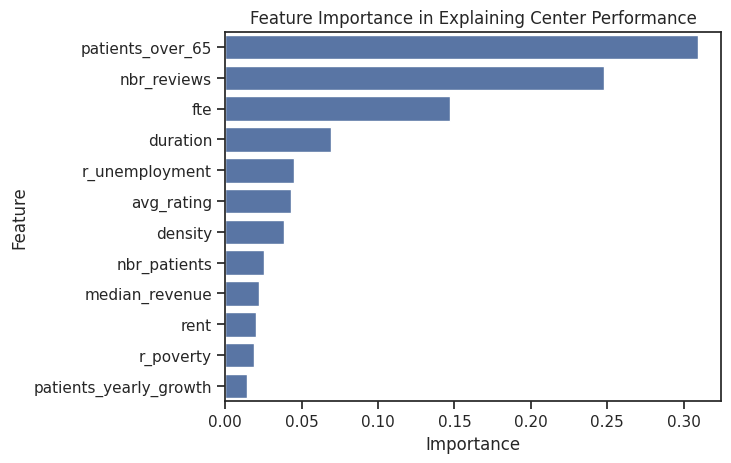

In [182]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

In [ ]:
### Doing so with XGBoostr Regressor too

In [186]:
xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],   # Example values for n_estimators
    'max_depth': [3, 5, 7, None]     # Example values for max_depth (use None for no limit)
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=loo, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search.fit(X, y)

# Retrieve best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE to positive

print("Best Parameters:", best_params)
print(f"Best Mean Squared Error (MSE): {best_score:.4f}")

# Evaluate with R² on LOOCV predictions if desired
y_pred = grid_search.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 71 folds for each of 12 candidates, totalling 852 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 10}
Best Mean Squared Error (MSE): 0.0202
R² Score: 0.8734


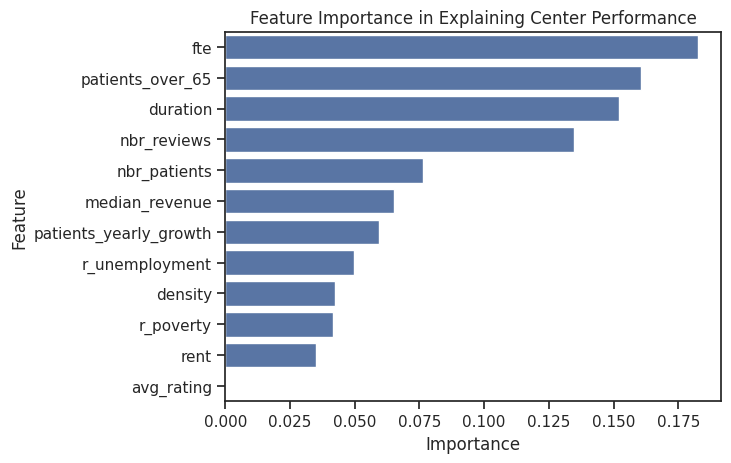

In [190]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

##### Conclusion

In [192]:
print(importance_df)

                   Feature  Importance
0                      fte    0.182477
6         patients_over_65    0.160698
11                duration    0.152137
1              nbr_reviews    0.134772
4             nbr_patients    0.076457
7           median_revenue    0.065326
5   patients_yearly_growth    0.059287
8           r_unemployment    0.049626
10                 density    0.042334
9                r_poverty    0.041692
3                     rent    0.035193
2               avg_rating    0.000000


#### deuxième stratégie

In [194]:
data_transform2 = data_transform.copy()

In [196]:
data_transform2['target'] = data_transform2['revenue'] * data_transform2['r_margin'] /data_transform2['fte']

X = data_transform1.drop(['target','revenue','r_margin','fte'], axis = 1)
y = data_transform1['target']

In [198]:
model2 = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [3,5,10,50, 100],   # Example values for n_estimators
    'max_depth': [2,3,4]     # Example values for max_depth
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid, cv=loo, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search2.fit(X, y)

best_model2 = grid_search.best_estimator_
best_params2= grid_search.best_params_
best_score2 = -grid_search.best_score_  # Convert from negative MSE

print("Best Parameters:", best_params2)
print(f"Best Mean Squared Error (MSE): {best_score2:.4f}")

y_pred = grid_search2.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 71 folds for each of 15 candidates, totalling 1065 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 50}
Best Mean Squared Error (MSE): 0.0193
R² Score: 0.6412


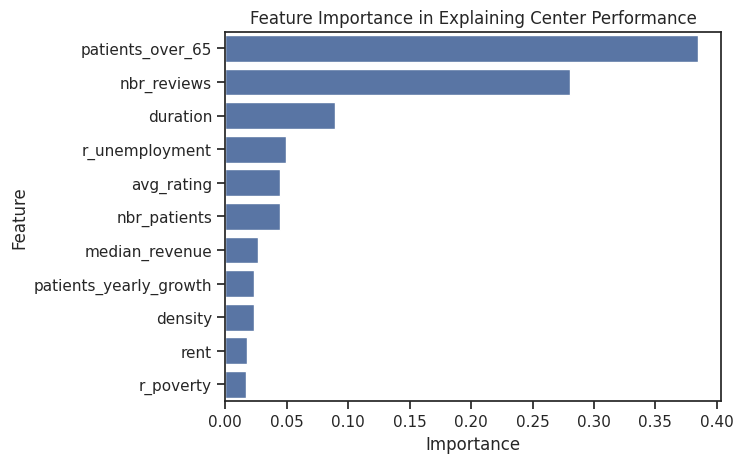

In [199]:
feature_importances = best_model2.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

In [ ]:
#####Deuxieme modele

In [200]:
xgb2 = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],   # Example values for n_estimators
    'max_depth': [3, 5, 7, None]     # Example values for max_depth (use None for no limit)
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search2 = GridSearchCV(estimator=xgb2, param_grid=param_grid, cv=loo, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search2.fit(X, y)

# Retrieve best model and parameters
best_model2 = grid_search2.best_estimator_
best_params2 = grid_search.best_params_
best_score2 = -grid_search.best_score_  # Convert from negative MSE to positive

print("Best Parameters:", best_params2)
print(f"Best Mean Squared Error (MSE): {best_score2:.4f}")

# Evaluate with R² on LOOCV predictions if desired
y_pred = grid_search2.predict(X)
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 71 folds for each of 12 candidates, totalling 852 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 50}
Best Mean Squared Error (MSE): 0.0193
R² Score: 0.9766


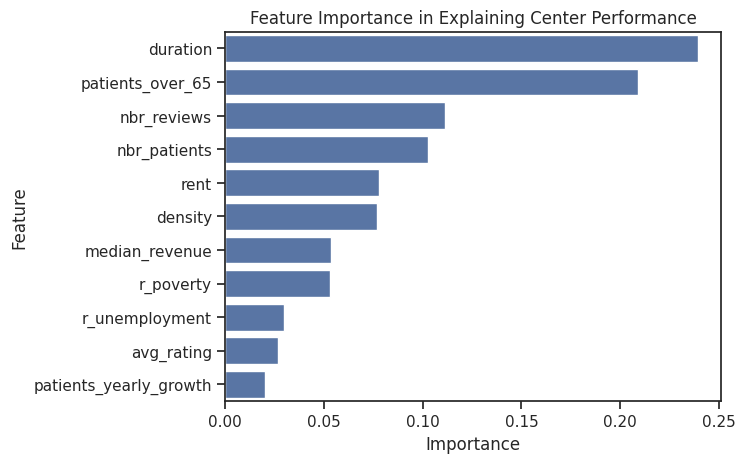

In [201]:
feature_importances = best_model2.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

##### Conclusion

balbala

Aurait on pu conclure avant d'utiliser ces modeles ?
Parmis les 10 premières (en terme d'importance) variables, 4 sont internes et 6 externes aux cabinets -> premiere conclusion possible   

## Question 3

Use an unsupervised learning technique to **cluster the dental centers**. How would you describe each cluster to the client in business terms?

In [214]:
best_score = -1
best_k = 0

for k in range(2, 9):

    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = clustering.fit_predict(data_transform)


    score = silhouette_score(X, labels)
    print(f"Nombre de clusters: {k}, Score de silhouette: {score}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score de silhouette de : {best_score}")

Nombre de clusters: 2, Score de silhouette: 0.5146011276556925
Nombre de clusters: 3, Score de silhouette: 0.5985381175281438
Nombre de clusters: 4, Score de silhouette: 0.5175277776248589
Nombre de clusters: 5, Score de silhouette: 0.5629637722459411
Nombre de clusters: 6, Score de silhouette: 0.5184175083635814
Nombre de clusters: 7, Score de silhouette: 0.521848163067029
Nombre de clusters: 8, Score de silhouette: 0.5058031235748004
Meilleur nombre de clusters : 3 avec un score de silhouette de : 0.5985381175281438


In [219]:
clustering = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(data_transform)

# Ajouter les labels aux données pour analyse
df = pd.DataFrame(data_transform, columns=data_transform.columns)  # Remplacez par les noms réels de vos colonnes
df['Cluster'] = labels
df.columns

Index(['revenue', 'r_margin', 'fte', 'nbr_reviews', 'avg_rating', 'rent',
       'nbr_patients', 'patients_yearly_growth', 'patients_over_65',
       'median_revenue', 'r_unemployment', 'r_poverty', 'density', 'duration',
       'Cluster'],
      dtype='object')

In [222]:
p_values = {}

for column in df.columns[:-1]:  # Ignorez la première colonne qui est 'Population'
    groups = [group[column].values for name, group in df.groupby('Cluster')]
    F_stat, p_value = stats.f_oneway(*groups)
    p_values[column] = p_value

# Convertir en DataFrame pour faciliter le tri
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [223]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [224]:
p_values_df

,Variable,p_value
6,nbr_patients,2.687734e-29
5,rent,5.856150e-19
12,density,3.396670e-14
9,median_revenue,5.960550e-09
10,r_unemployment,1.388592e-05
4,avg_rating,8.346562e-04
11,r_poverty,6.380005e-03
3,nbr_reviews,2.896750e-02
7,patients_yearly_growth,4.392728e-02
8,patients_over_65,6.025005e-02


In [225]:
most_discriminant_variable = p_values_df.iloc[0]
print(f"Variable la plus discriminante : {most_discriminant_variable['Variable']}, p-value : {most_discriminant_variable['p_value']}")

Variable la plus discriminante : nbr_patients, p-value : 2.687734139649366e-29


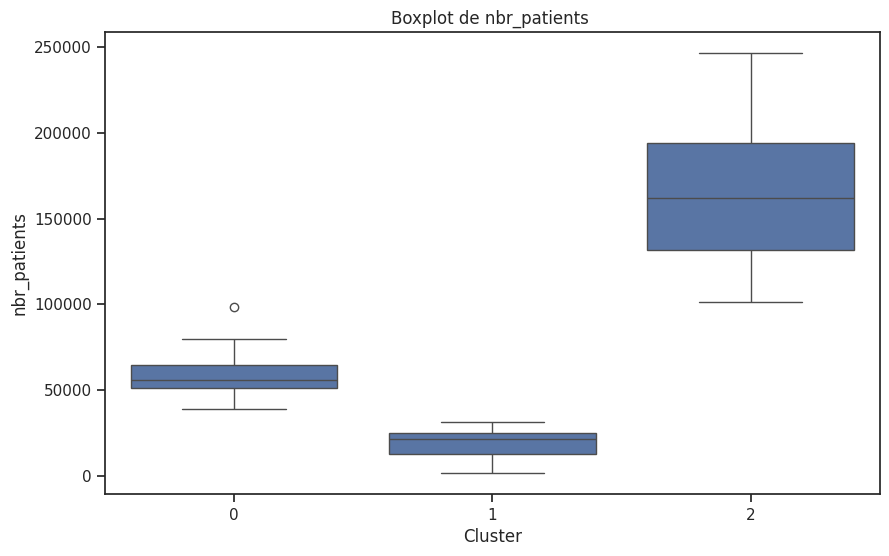

In [229]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=most_discriminant_variable['Variable'], data=df)
plt.title(f'Boxplot de {most_discriminant_variable["Variable"]} ')
plt.show()

Les cabinets seront donc à distinguer en trois catégories possibles :

- Les centres à forte demande
- Les centres en développement, certes dans une zone moins peuplée, ils ont tout de même un fort potentiel de développement
- Centres spécialisés à faible densité : Situés dans des zones de faible densité de population, ces centres se distinguent souvent par une spécialisation

## Question 4

Let's **enrich our dataset** with additional data on competition. Download the following file providing an overview of all medical institutions in France with their geo coordinates and convert it to a clean dataframe: https://www.data.gouv.fr/fr/datasets/r/98f3161f-79ff-4f16-8f6a-6d571a80fea2.

Perform the necessary **filters to separate dental centers** from the other institutions.

**Reproject the geo coordinates** to the ESPG:4326 coordinate reference system (same as the coordinates in the dental center dataset).

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [ ]:
data_sup = pd.read_csv('etalab-cs1100507-stock-20240909-0338.csv')

## Question 5

Let's **assess competitive intensity** around the dental centers. First **draw a circle with a 500 meter radius** around each of the 71 dental center (under the form of a POLYGON). We will refer to these shapes as center catchment areas.
Then, **compute the number of competitors**, i.e. dental centers from the dataset you built in question 4 within each catchment area. Name this variable competitive intensity.

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [ ]:
# your code here



## Question 6

Now let's **perform the explanatory analysis of question 2 and the clustering of question 3 again**, taking competitive intensity into account. Do the results change, and if so how and why?

In [ ]:
# your code here



## Question 7

**Summarize your findings** in business terms and formulate a recommendation on how to improve the overall dental center network performance based on the answers to the previous questions.

**Note: for this question no code is expected**

In [ ]:
# your awnser

